In [12]:
#import libraries
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
#Load training dataset
train_data = pd.read_csv('../data/training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [3]:
#Inspect dataset
pandas_profiling.ProfileReport(train_data)

C:\Users\samee\Anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,10
Number of observations,84534
Total Missing (%),0.0%
Total size in memory,6.4 MiB
Average record size in memory,80.0 B
Numeric,6
Categorical,1
Boolean,3
Date,0
Text (Unique),0
Rejected,0


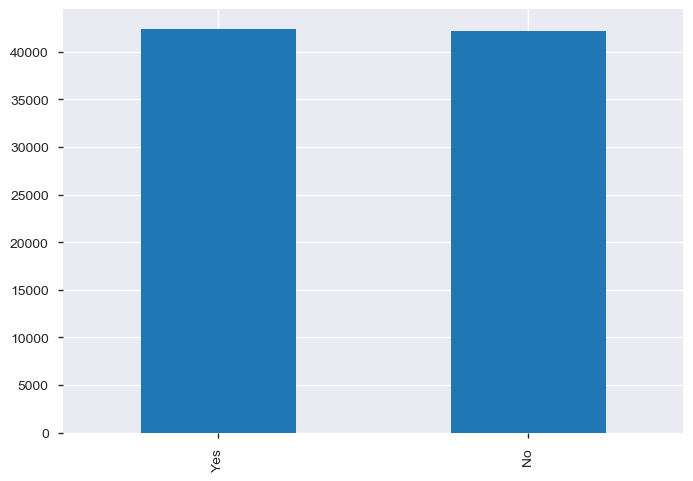

In [4]:
# Inspect class distributions
train_data.Promotion.value_counts().plot.bar()

Class distributions are approximately equal so there is no need for up-sampling

In [21]:
# Seperate the data into X_train and y_train
X_train = train_data.drop(['ID', 'Promotion', 'purchase'], axis=1)
y_train = np.array([1 if i=='Yes' and j==1 else 0 for (i,j) in zip(train_data.Promotion.tolist(), train_data.purchase.tolist())])

In [28]:
# Build custom column selector
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.columns].values.reshape(len(X), -1)

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('cat_pipeline', Pipeline([
            ('selector', ColumnSelector(X_train.drop('V2', axis=1).columns)),
            ('encoder', OneHotEncoder(sparse=False, categories='auto'))
        ])),
        
        ('num_pipeline', Pipeline([
            ('selector', ColumnSelector('V2')),
            ('scalar', StandardScaler())
        ]))
    ])),
    
    ('clf', RandomForestClassifier(n_jobs=-1))
])

params = {
    'clf__n_estimators': [100, 150, 200],
    'clf__max_depth': [3,4,5],
    'clf__min_samples_split': [2,3,4],
}

model = GridSearchCV(pipeline, param_grid=params, scoring='accuracy', cv=3, verbose=3, n_jobs=-1)
model.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  6.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('cat_pipeline',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('selector',
                                                                                         ColumnSelector(columns=Index(['V1', 'V3', 'V4', 'V5', 'V6', 'V7'], dtype='object'))),
                                                                                        ('encoder',
                                                                                         OneHotEncoder(categorical_features=None,
                                                                                                 

In [31]:
model.best_score_

0.9914708874535689